In [43]:
from typing import TypedDict, List, Dict, Any, Optional
from typing import Optional

class QAState(TypedDict):

    # The question that user asks
    question: str

    # The question type (reverse, logic)
    type: str

    # The final answer
    answer: Optional[str] = None

In [44]:
from langchain_community.llms import Ollama

llm = Ollama(model="llama3", temperature=0)

In [ ]:
def read_question(state: QAState):
	print(f"Read question: \n{state['question']}")

	return {}

def answer_question(state: QAState):
    prompt = f"""
    Answer this question clearly and concisely. No explanation.

    Question: {state['question']}
    """
    response = llm.invoke(prompt)
    return {
        "answer": response
	}

def classify_question_type(state: QAState) -> QAState:
    prompt = f"""
	Read the question carefully and classify it into one of these types:
	- 'reverse': the question is written backwards or reversed.
	- 'logic': the question is a logic puzzle or involves logical reasoning.
	- 'others': the question did not belong to reverse nor logic categories.

	Examples:
	Q: "If you write the word 'left' backwards, can you read this sentence?"
	A: reverse

	Q: "Given a set and an operation table, find counterexamples to commutativity."
	A: logic

	Q: "How old is Bob?"
	A: others

	You just have to respond concisely with exactly one word from the above options.

	Now, classify this question:

	Question: {state['question']}
	"""

    response = llm.invoke(prompt)
    print(f"The type is likely to be \'{response}\'")
    return {
        "type": response
	}

def route_by_type(state: QAState) -> str:
    return state['type']

def reverse_sentence(state: QAState) -> QAState:
    return {
        "question": state['question'][::-1]
	}

def analyze_logic_node(state: dict):
    
	def extract_markdown_table(question: str) -> str:
		lines = question.strip().splitlines()
		table_lines = [line for line in lines if "|" in line]
		return "\n".join(table_lines)
    
	def parse_table_markdown(markdown_table: str) -> dict[tuple[str, str], str]:
		lines = markdown_table.strip().splitlines()
		headers = lines[0].split("|")[1:]  # skip first empty column
		table = {}
		for row in lines[2:]:  # skip header + --- line
			cells = row.split("|")[1:]
			row_label = cells[0].strip()
			for col_label, val in zip(headers[1:], cells[1:]):
				table[(row_label.strip(), col_label.strip())] = val.strip()
		return table
	
	def find_commutativity_violations(table: dict[tuple[str, str], str]) -> set[str]:
		elements = {a for a, _ in table.keys()}
		violating = set()
		for a in elements:
			for b in elements:
				if table[(a, b)] != table[(b, a)]:
					violating.update([a, b])
		return sorted(violating)

	table_md = extract_markdown_table(state["question"])
	parsed_table = parse_table_markdown(table_md)
	violating = find_commutativity_violations(parsed_table)

	return {
		"answer": ",".join(violating) if violating else "None"
	}


In [ ]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(QAState)

# add nodes
builder.add_node("read", read_question)
builder.add_node("classify_type", classify_question_type)
builder.add_node("answering", answer_question)
builder.add_node("reverse", reverse_sentence)
builder.add_node("logic_table", analyze_logic_node)

# edges
builder.add_edge(START, "read")
builder.add_edge("read", "classify_type")
builder.add_edge("reverse", "answering")
builder.add_edge("answering", END)
builder.add_edge("logic_table", END)

# branching
builder.add_conditional_edges(
    "classify_type",
    route_by_type,
    {
        "reverse": "reverse",
        "logic": "logic_table",
        "others": "answering"
    }
)

# Compile graph
graph = builder.compile()

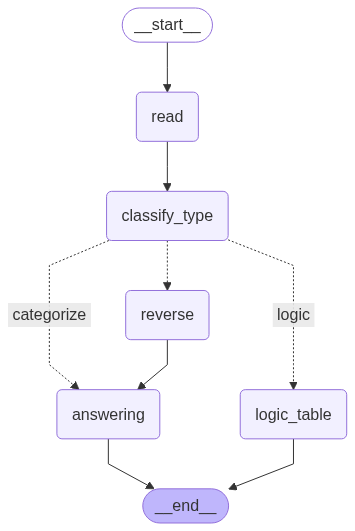

In [77]:
from IPython.display import Image, display

png_bytes = graph.get_graph().draw_mermaid_png()
with open("graph.png", "wb") as f:
    f.write(png_bytes)

display(Image(filename="graph.png"))

In [78]:
user_question = """I'm making a grocery list for my mom, but she's a professor of botany and she's a real stickler when it comes to categorizing things. I need to add different foods to different categories on the grocery list, but if I make a mistake, she won't buy anything inserted in the wrong category. Here's the list I have so far:
milk, eggs, flour, whole bean coffee, Oreos, sweet potatoes, fresh basil, plums, green beans, rice, corn, bell pepper, whole allspice, acorns, broccoli, celery, zucchini, lettuce, peanuts
I need to make headings for the fruits and vegetables. Could you please create a list of just the vegetables from my list? If you could do that, then I can figure out how to categorize the rest of the list into the appropriate categories. But remember that my mom is a real stickler, so make sure that no botanical fruits end up on the vegetable list, or she won't get them when she's at the store. Please alphabetize the list of vegetables, and place each item in a comma separated list."""

In [79]:
state = graph.invoke({"question": user_question})
print("Final Answer:", state['answer'])

Read question: 
I'm making a grocery list for my mom, but she's a professor of botany and she's a real stickler when it comes to categorizing things. I need to add different foods to different categories on the grocery list, but if I make a mistake, she won't buy anything inserted in the wrong category. Here's the list I have so far:
milk, eggs, flour, whole bean coffee, Oreos, sweet potatoes, fresh basil, plums, green beans, rice, corn, bell pepper, whole allspice, acorns, broccoli, celery, zucchini, lettuce, peanuts
I need to make headings for the fruits and vegetables. Could you please create a list of just the vegetables from my list? If you could do that, then I can figure out how to categorize the rest of the list into the appropriate categories. But remember that my mom is a real stickler, so make sure that no botanical fruits end up on the vegetable list, or she won't get them when she's at the store. Please alphabetize the list of vegetables, and place each item in a comma sep